# Data processing

## Load data

In [287]:
from utils import *

import matplotlib.pyplot as plt
import seaborn as sb
from copy import deepcopy

%matplotlib inline

account_df = read_to_df("account.csv")
card_test_df = read_to_df("card_test.csv")
card_train_df = read_to_df("card_train.csv")
client_df = read_to_df("client.csv")
disp_df = read_to_df("disp.csv")
district_df = read_to_df("district.csv")
loan_test_df = read_to_df("loan_test.csv")
loan_train_df = read_to_df("loan_train.csv")
trans_test_df = read_to_df("trans_test.csv")
trans_train_df = read_to_df("trans_train.csv")

C:\Users\skelo\AppData\Local\Temp/ipykernel_1496/160468940.py:18: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  trans_train_df = read_to_df("trans_train.csv")


## Process data

### Process account data

In [288]:
avg_transactions_per_week = 3
avg_weeks_per_month = (365.25 / 7 / 12)

account_df['frequency'] = account_df['frequency'].apply(lambda x: 1 if x == 'monthly issuance' else avg_weeks_per_month if x == 'weekly issuance' else (365.25 / 7 / 12) * avg_transactions_per_week)
account_df["date"] = account_df["date"].apply(lambda x: read_date(x))
account_df.rename(columns={"date": "creation_date", "frequency": "issuance_frequency_per_month"}, inplace=True)

account_df.head()

,account_id,district_id,issuance_frequency_per_month,creation_date
0,576,55,1.0,1993-01-01
1,3818,74,1.0,1993-01-01
2,704,55,1.0,1993-01-01
3,2378,16,1.0,1993-01-01
4,2632,24,1.0,1993-01-02


### Process client data

In [289]:
client_df["sex"] = client_df["birth_number"].apply(lambda x: 0 if int(str(x)[2:4]) > 50 else 1)
client_df["age"] = client_df["birth_number"].apply(lambda x: calculate_age(read_date(x)))

client_df.drop("birth_number", inplace=True, axis=1)

client_df.head()

,client_id,district_id,sex,age
0,1,18,0,28
1,2,1,1,53
2,3,1,0,58
3,4,5,1,42
4,5,5,0,38


### Process disposition data

In [290]:
disp_df.rename(columns={"type": "is_owner"}, inplace=True)
disp_df["is_owner"].replace({"OWNER": True, "DISPONENT": False}, inplace=True)

# Count number clients per account
client_count_df = disp_df.groupby("account_id", as_index=False, group_keys=False).agg(client_count_per_acc=("is_owner", "count"))

disp_df = disp_df.merge(client_count_df, on="account_id")
disp_df = disp_df[disp_df["is_owner"] == True] 
disp_df.drop("is_owner", axis=1, inplace=True)

disp_df.head()

,disp_id,client_id,account_id,client_count_per_acc
0,1,1,1,1
1,2,2,2,2
3,4,4,3,2
5,6,6,4,1
6,7,7,5,1


### Process transaction data

In [291]:
dataframes = [trans_train_df, trans_test_df]

for i in range(len(dataframes)):
    dataframes[i]["operation"].replace(
        {
            "credit in cash": 1,
            "collection from another bank": 2,
            "withdrawal in cash": 3,
            "remittance to another bank": 4,
            "credit card withdrawal": 5,
            "interest credited": 6
        },
        inplace=True
    )

    # Convert "withdrawal in cash" to "withdrawal" in type column
    dataframes[i].loc[dataframes[i]["type"] == "withdrawal in cash", "type"] = "withdrawal"

    # Withdrawal amounts should be negative
    dataframes[i].loc[dataframes[i]["type"] == "withdrawal", "amount"] *= -1

    dataframes[i].drop(["k_symbol", "bank"], axis=1, inplace=True)

trans_train_df, trans_test_df = dataframes

trans_train_df.head()

,trans_id,account_id,date,type,operation,amount,balance,account
0,1548749,5270,930113,credit,1.0,800.0,800.0,NaN
1,1548750,5270,930114,credit,2.0,44749.0,45549.0,80269753.0
2,3393738,11265,930114,credit,1.0,1000.0,1000.0,NaN
3,3122924,10364,930117,credit,1.0,1100.0,1100.0,NaN
4,1121963,3834,930119,credit,1.0,700.0,700.0,NaN


### Process card data

In [292]:
dataframes = [card_train_df, card_test_df]

for i in range(len(dataframes)):
    dataframes[i]["type"].replace({"classic": 1, "junior": 2, "gold": 3}, inplace=True)

card_train_df, card_test_df = dataframes

card_train_df.head()

,card_id,disp_id,type,issued
0,1005,9285,1,931107
1,104,588,1,940119
2,747,4915,1,940205
3,70,439,1,940208
4,577,3687,1,940215


### Process demographic data

In [293]:
district_df.replace("?", np.NaN, inplace=True)
district_df.dropna(inplace=True)

## Process loan data

In [294]:
loan_dfs = [loan_train_df, loan_test_df]

for i in range(len(loan_dfs)):
    loan_dfs[i]["date"] = loan_dfs[i]["date"].apply(lambda x: read_date(x))
    loan_dfs[i].rename(columns={"date": "loan_date"}, inplace=True)

## Generate feature from transaction data

In [295]:
transactions = (trans_train_df, trans_test_df)
account_features = [1, 2]

for i in range(len(transactions)):
    # Sorting transactions by date to figure out the most recent balance
    account_features[i] = transactions[i].sort_values(by="date", axis=0, ascending=False)
    account_features[i].drop_duplicates(subset='account_id', keep='first', inplace=True)

    account_features[i].drop(account_features[i].columns.difference(['account_id', 'balance']), axis=1, inplace=True)
    account_features[i].rename(columns={'balance': 'final_amount'}, inplace=True)

account_features[0]

,account_id,final_amount
396684,1770,68162.9
393038,3039,32166.2
393030,3076,24233.8
393031,3045,28237.6
393032,3030,21804.5
...,...,...
1716,11013,41142.9
1155,1843,34307.3
1091,9188,20272.8
965,1801,52208.9


## Merge data

In [296]:
loan_dfs = [loan_train_df, loan_test_df]
trans_dfs = (trans_train_df, trans_test_df)
cards_dfs = (card_train_df, card_test_df)

for i in range(len(loan_dfs)):
    # Merge with dispositions
    loan_dfs[i] = loan_dfs[i].merge(disp_df, on="account_id", how="left")

    # Merge with accounts
    loan_dfs[i] = loan_dfs[i].merge(account_df, on="account_id")

    # Merge with clients
    loan_dfs[i] = loan_dfs[i].merge(client_df, on="client_id", suffixes=["_account", "_client"])

    # Merge with districts
    # loan_dfs[i] = loan_dfs[i].merge(district_df, left_on="district_id_client", right_on="code")

    # Merge with cards
    loan_dfs[i] = loan_dfs[i].merge(cards_dfs[i], on="disp_id", how="left")

    # Merge with transactions
    loan_dfs[i] = loan_dfs[i].merge(account_features[i], on="account_id")

loan_train_df, loan_test_df = loan_dfs

# loan_train_df
with pd.option_context('display.max_rows', 15, 'display.max_columns', None): 
    display(loan_train_df)

,loan_id,account_id,loan_date,amount,duration,payments,status,disp_id,client_id,client_count_per_acc,district_id_account,issuance_frequency_per_month,creation_date,district_id_client,sex,age,card_id,type,issued,final_amount
0,5314,1787,1993-07-05,96396,12,8033,-1,2166,2166,1,30,4.348214,1993-03-22,30,0,51,NaN,NaN,NaN,20100.0
1,5316,1801,1993-07-11,165960,36,4610,1,2181,2181,1,46,1.000000,1993-02-13,46,1,30,NaN,NaN,NaN,52208.9
2,6863,9188,1993-07-28,127080,60,2118,1,11006,11314,1,45,1.000000,1993-02-08,45,1,62,NaN,NaN,NaN,20272.8
3,5325,1843,1993-08-03,105804,36,2939,1,2235,2235,1,12,1.000000,1993-01-30,14,0,58,NaN,NaN,NaN,34307.3
4,7240,11013,1993-09-06,274740,60,4579,1,13231,13539,1,1,4.348214,1993-02-14,63,1,20,NaN,NaN,NaN,41142.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,1996-12-12,155616,48,3242,1,10813,11121,2,72,1.000000,1995-01-21,72,0,27,NaN,NaN,NaN,60694.1
324,5625,3189,1996-12-15,222180,60,3703,-1,3855,3855,1,29,1.000000,1995-11-29,29,1,59,NaN,NaN,NaN,59578.8
325,6805,8972,1996-12-21,45024,48,938,1,10742,11050,1,70,1.000000,1996-05-21,70,0,41,NaN,NaN,NaN,38384.3
326,7233,10963,1996-12-25,115812,36,3217,1,13172,13480,1,16,1.000000,1995-05-20,16,1,45,NaN,NaN,NaN,41878.1


## Dropping features

- All cards can be dropped as there are only 11 out of the total 328 loans making it very hard or impossible to fill in missing values.
- IDs are no longer needed

In [297]:
loan_dfs = [loan_train_df, loan_test_df]

for i in range(len(loan_dfs)):
    loan_dfs[i].drop(["card_id", "type", "issued"], axis=1, inplace=True)
    loan_dfs[i].drop(["disp_id", "account_id", "client_id"], axis=1, inplace=True)
    # loan_train_df.drop(["district_id_account", "district_id_client", "code"], axis=1, inplace=True)
    loan_dfs[i].drop(["loan_date", "creation_date"], axis=1, inplace=True)

KeyError: "['loan_id'] not found in axis"

## Aggregate data 

In [ ]:
keep_cols = [
    "loan_id",
    "account_id",
    "status",
    "loan_date",
    "creation_date",
    "amount",
    "duration",
    "payments",
    "sex",
    "client_count_per_acc",
    "district_id_account",
    "no. of inhabitants",
    "no. of municipalities with inhabitants < 499",
    "no. of municipalities with inhabitants 500-1999",
    "no. of municipalities with inhabitants 2000-9999",
    "no. of municipalities with inhabitants >10000",
    'no. of cities',
    'ratio of urban inhabitants',
    'average salary',
    "unemploymant rate '95",
    "unemploymant rate '96",
    'no. of enterpreneurs per 1000 inhabitants',
    "no. of commited crimes '95",
    "no. of commited crimes '96"
]

def aggregate(df):
    df = df.groupby(keep_cols, as_index=False, group_keys=False).agg({
        "loan_date": ["max", "min"],
        #"operation": ["count"],
        "final_amount": ["mean", "min", "max", "std", "last"],
        # "balance": ["mean", "min", "max", "std", "last"],
    })

    df.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df.columns]
    df["days_last_trans_loan"] = (df["loan_date"] - df["date_max"]).dt.days
    df["last_balance_per_loan"] = df["balance_last"] / df["amount"]
    df["max_balance_per_loan"] = df["balance_max"] / df["amount"]
    df["balance_per_month"] = df["balance_range"] / df["date_age_months"]
    df["transactions_per_month"] = df["operation_count"] / df["date_age_months"]

    df['account_months_at_loan'] = ((df['loan_date'] - df['creation_date']).dt.days) / 30  # cast to months
#     df.account_age_at_loan = df.account_age_at_loan.astype(int) # convert to int

    return df


In [ ]:
# loan_train_df = aggregate(loan_train_df)
# loan_test_df = aggregate(loan_test_df)

## Visualization

### Age

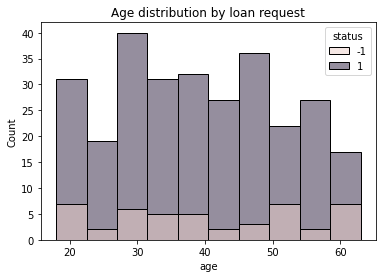

In [ ]:
sb.histplot(data=loan_train_df, x="age", hue="status").set(title="Age distribution by loan request");

## Region

In [ ]:
# sb.barplot(data=loan_train_df, x="name", y=loan_train_df.groupby("name").value_counts)

### Pairplot

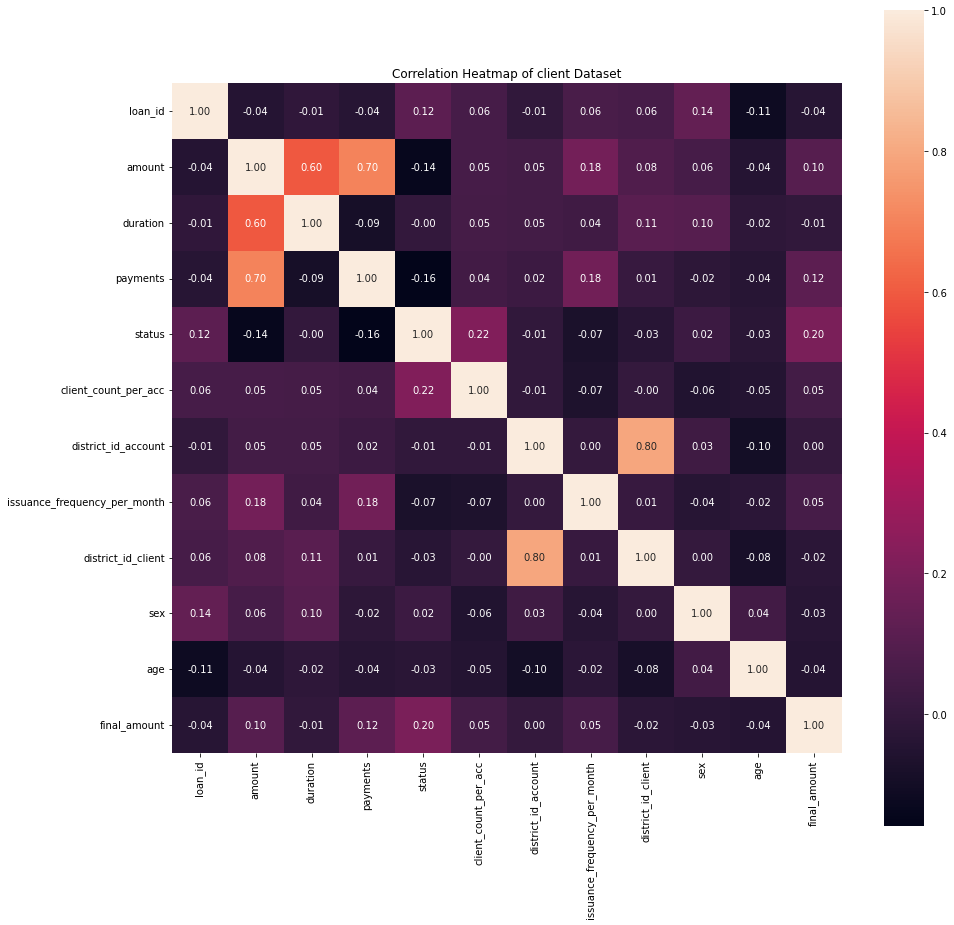

In [ ]:
corr_matrix = loan_train_df.corr(method='spearman')

plt.figure(figsize=(15,15))
plt.title('Correlation Heatmap of client Dataset')

sb.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')

plt.show()

## Export preprocessed dataframes

In [ ]:
loan_train_df.to_pickle("../out/train.pkl")
loan_test_df.to_pickle("../out/test.pkl")